In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

IMG_SIZE = 32
NUM_CLASSES = 43
NUM_SAMPLES = 5000

class_names = [
    'Speed limit (20km/h)', 'Speed limit (30km/h)', 'Speed limit (50km/h)',
    'Speed limit (60km/h)', 'Speed limit (70km/h)', 'Speed limit (80km/h)',
    'End of speed limit (80km/h)', 'Speed limit (100km/h)', 'Speed limit (120km/h)',
    'No passing', 'No passing veh over 3.5 tons', 'Right-of-way at intersection',
    'Priority road', 'Yield', 'Stop', 'No vehicles', 'Veh > 3.5 tons prohibited',
    'No entry', 'General caution', 'Dangerous curve left', 'Dangerous curve right',
    'Double curve', 'Bumpy road', 'Slippery road', 'Road narrows on the right',
    'Road work', 'Traffic signals', 'Pedestrians', 'Children crossing',
    'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing',
    'End speed + passing limits', 'Turn right ahead', 'Turn left ahead',
    'Ahead only', 'Go straight or right', 'Go straight or left', 'Keep right',
    'Keep left', 'Roundabout mandatory', 'End of no passing',
    'End no passing veh > 3.5 tons'
]

def create_synthetic_traffic_sign(class_id, img_size=32):
    img = np.random.randint(50, 200, (img_size, img_size, 3), dtype=np.uint8)
    
    if class_id < 9:
        cv2.circle(img, (img_size//2, img_size//2), img_size//3, (255, 255, 255), -1)
        cv2.circle(img, (img_size//2, img_size//2), img_size//3-2, (255, 0, 0), 2)
        cv2.putText(img, str(class_id*10+20), (img_size//4, img_size//2+2), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 0), 1)
    elif class_id < 18:
        pts = np.array([[img_size//2, img_size//4], [img_size//4, 3*img_size//4], 
                       [3*img_size//4, 3*img_size//4]], np.int32)
        cv2.fillPoly(img, [pts], (255, 255, 0))
        cv2.polylines(img, [pts], True, (255, 0, 0), 2)
    elif class_id < 33:
        pts = np.array([[img_size//2, img_size//4], [img_size//4, 3*img_size//4], 
                       [3*img_size//4, 3*img_size//4]], np.int32)
        cv2.fillPoly(img, [pts], (255, 255, 255))
        cv2.polylines(img, [pts], True, (255, 0, 0), 2)
    else:
        cv2.circle(img, (img_size//2, img_size//2), img_size//3, (0, 0, 255), -1)
        cv2.circle(img, (img_size//2, img_size//2), img_size//4, (255, 255, 255), -1)
    
    noise = np.random.normal(0, 10, img.shape)
    img = np.clip(img + noise, 0, 255).astype(np.uint8)
    
    return img

X_data = []
y_data = []

for class_id in range(NUM_CLASSES):
    samples_per_class = NUM_SAMPLES // NUM_CLASSES + (1 if class_id < NUM_SAMPLES % NUM_CLASSES else 0)
    for _ in range(samples_per_class):
        img = create_synthetic_traffic_sign(class_id, IMG_SIZE)
        X_data.append(img)
        y_data.append(class_id)

X = np.array(X_data)
y = np.array(y_data)

print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Samples per class: {np.bincount(y)}")

Dataset shape: (5000, 32, 32, 3)
Labels shape: (5000,)
Number of classes: 43
Samples per class: [117 117 117 117 117 117 117 117 117 117 117 117 116 116 116 116 116 116
 116 116 116 116 116 116 116 116 116 116 116 116 116 116 116 116 116 116
 116 116 116 116 116 116 116]


In [3]:
print(f"Image data type: {X.dtype}")
print(f"Image value range: {X.min()} - {X.max()}")
print(f"Labels range: {y.min()} - {y.max()}")
print(f"Unique classes: {len(np.unique(y))}")

Image data type: uint8
Image value range: 0 - 255
Labels range: 0 - 42
Unique classes: 43


In [4]:
X_normalized = X.astype('float32') / 255.0

def preprocess_image(img):
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    img_eq = cv2.equalizeHist(img_gray)
    img_rgb = cv2.cvtColor(img_eq, cv2.COLOR_GRAY2RGB)
    return img_rgb

X_preprocessed = np.array([preprocess_image(img) for img in X])
X_preprocessed = X_preprocessed.astype('float32') / 255.0

y_categorical = to_categorical(y, NUM_CLASSES)

X_train, X_temp, y_train, y_temp = train_test_split(
    X_preprocessed, y_categorical, test_size=0.3, random_state=42, stratify=y
)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp.argmax(axis=1)
)

print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (3500, 32, 32, 3)
Validation set: (750, 32, 32, 3)
Test set: (750, 32, 32, 3)


In [5]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)
datagen.fit(X_train)

In [6]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 10, 10, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 3, 3, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 3, 3, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 754,763 (2.88 MB)

 Trainable params: 753,291 (2.87 MB)

 Non-trainable params: 1,472 (5.75 KB)

In [7]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=3)
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=20,
    validation_data=(X_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 9s 50ms/step - accuracy: 0.0566 - loss: 4.3247 - val_accuracy: 0.0227 - val_loss: 5.4625 - learning_rate: 0.0010
Epoch 2/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.0877 - loss: 3.5783 - val_accuracy: 0.0280 - val_loss: 4.8440 - learning_rate: 0.0010
Epoch 3/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.0891 - loss: 3.3709 - val_accuracy: 0.0467 - val_loss: 4.4354 - learning_rate: 0.0010
Epoch 4/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 44ms/step - accuracy: 0.1000 - loss: 3.2387 - val_accuracy: 0.0800 - val_loss: 3.1104 - learning_rate: 0.0010
Epoch 5/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.1111 - loss: 3.0887 - val_accuracy: 0.1627 - val_loss: 2.6875 - learning_rate: 0.0010
Epoch 6/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.1243 - loss: 3.0214 - val_accuracy: 0.1933 - val_loss: 2.6405 - learning_rate: 0.0010
Epoch 7/20
110/110 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.1351 - loss: 2.

In [8]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

accuracy = accuracy_score(y_true_classes, y_pred_classes)
print(f"\nAccuracy Score: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_true_classes, y_pred_classes, target_names=[f'Class_{i}' for i in range(NUM_CLASSES)]))

Test Accuracy: 0.1720
Test Loss: 2.6277
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Accuracy Score: 0.1720

Classification Report:
              precision    recall  f1-score   support

     Class_0       1.00      0.35      0.52        17
     Class_1       0.00      0.00      0.00        18
     Class_2       1.00      1.00      1.00        18
     Class_3       0.65      0.83      0.73        18
     Class_4       0.00      0.00      0.00        17
     Class_5       1.00      1.00      1.00        18
     Class_6       0.59      1.00      0.74        17
     Class_7       0.17      0.44      0.25        18
     Class_8       1.00      1.00      1.00        17
     Class_9       0.04      0.53      0.07        17
    Class_10       0.00      0.00      0.00        18
    Class_11       0.00      0.00      0.00        18
    Class_12       0.00      0.00      0.00        17
    Class_13       0.00      0.00      0.00        17
    Class_14       0.00      0.00      0.00        18
    Cla

In [9]:
cm = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix Shape:", cm.shape)
print("Top-5 Predicted Classes:", np.bincount(y_pred_classes).argsort()[-5:][::-1])
print("Top-5 True Classes:", np.bincount(y_true_classes).argsort()[-5:][::-1])

Confusion Matrix Shape: (43, 43)
Top-5 Predicted Classes: [ 9 39 27  7 21]
Top-5 True Classes: [42 40 38 32 35]


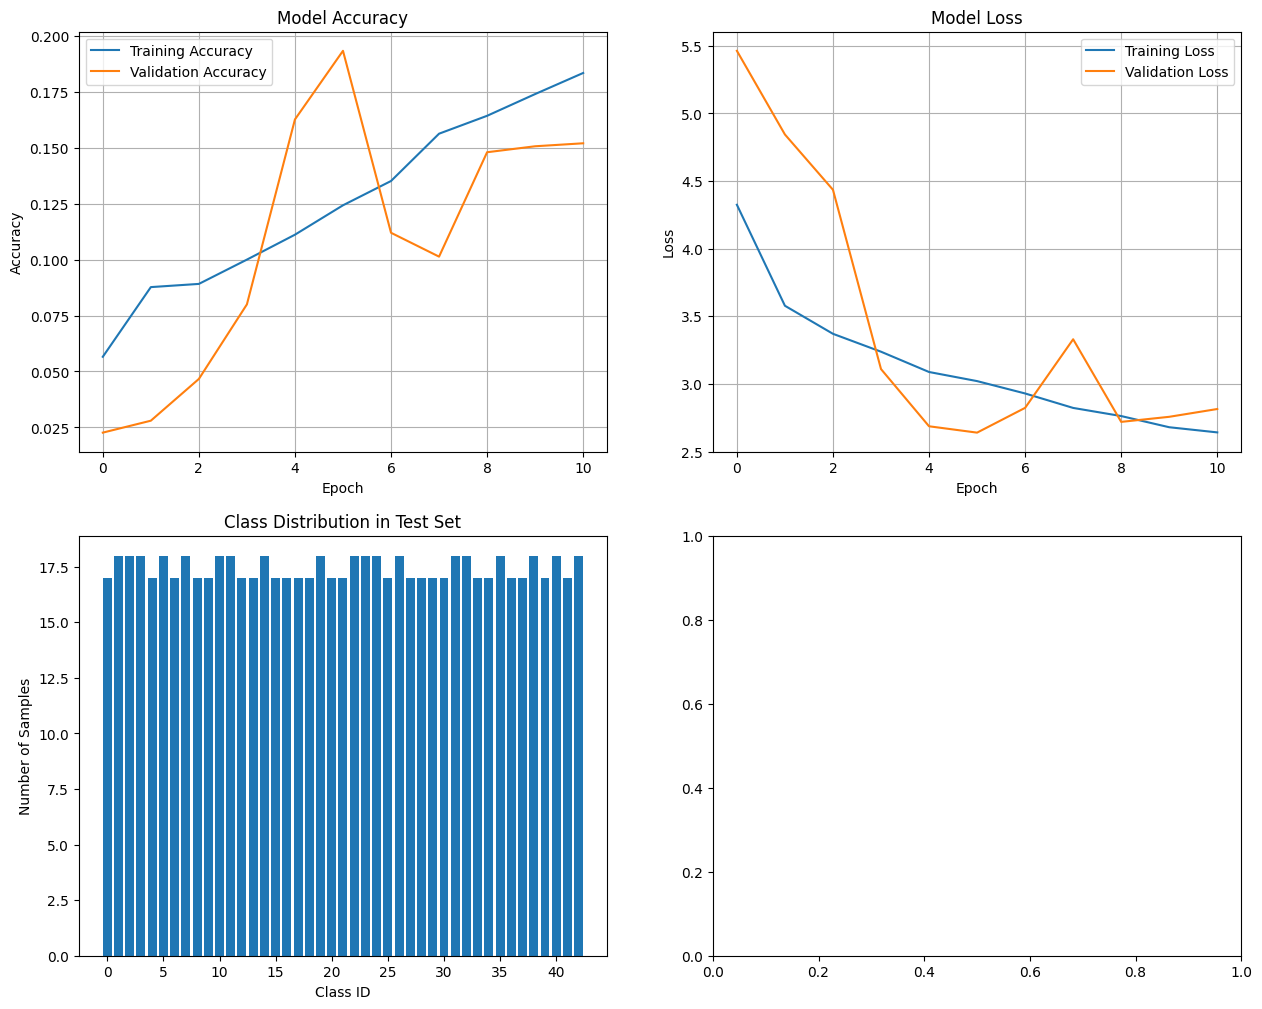

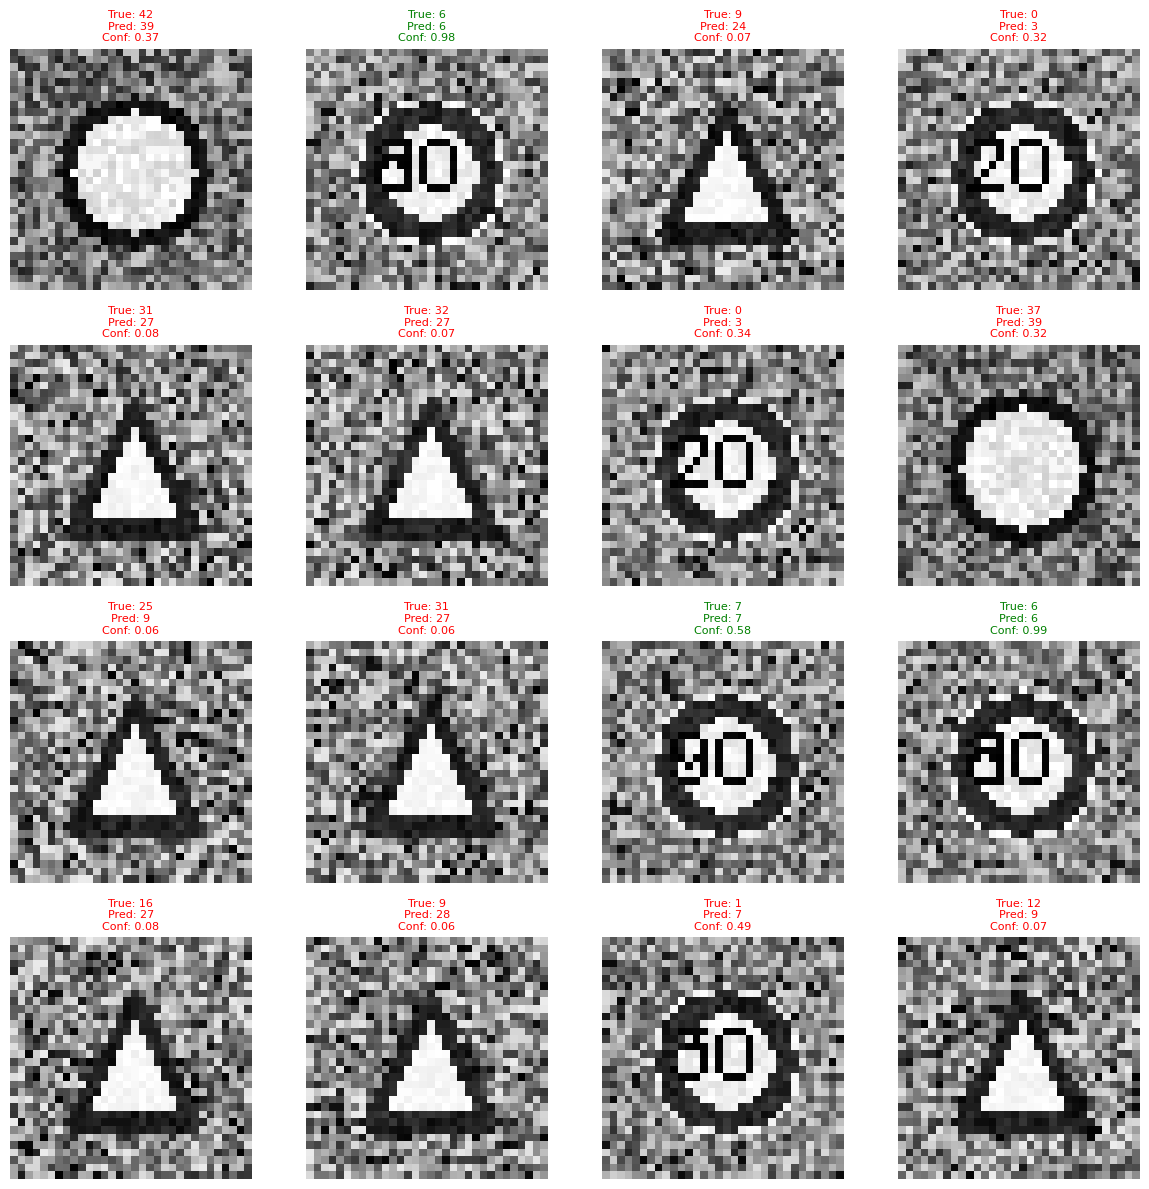

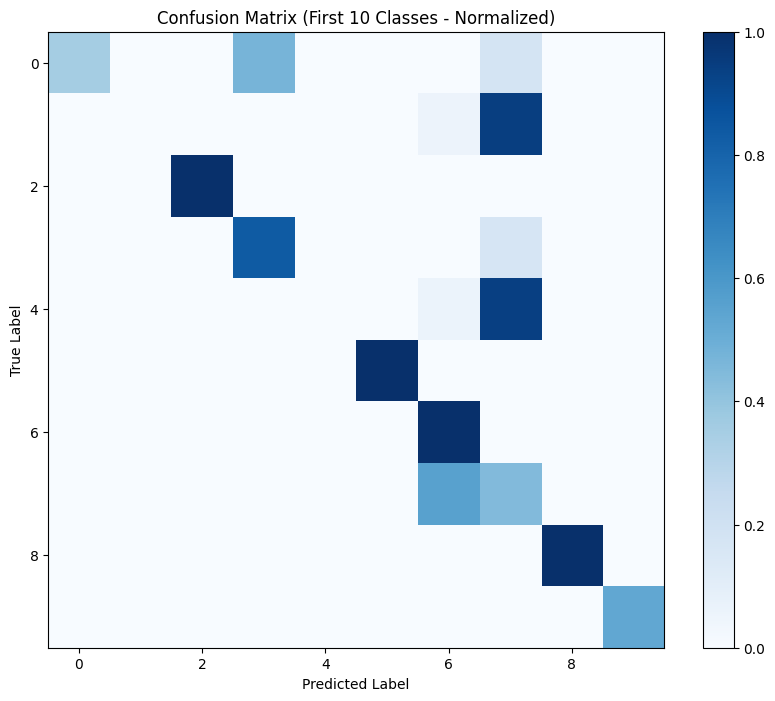

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot(history.history['loss'], label='Training Loss')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

class_distribution = np.bincount(y_true_classes)
axes[1, 0].bar(range(len(class_distribution)), class_distribution)
axes[1, 0].set_title('Class Distribution in Test Set')
axes[1, 0].set_xlabel('Class ID')
axes[1, 0].set_ylabel('Number of Samples')
axes[1, 0].set_xticks(range(0, NUM_CLASSES, 5))

sample_indices = np.random.choice(len(X_test), 16, replace=False)
fig2, axes2 = plt.subplots(4, 4, figsize=(12, 12))
for i, idx in enumerate(sample_indices):
    row, col = i // 4, i % 4
    axes2[row, col].imshow(X_test[idx])
    true_class = y_true_classes[idx]
    pred_class = y_pred_classes[idx]
    confidence = np.max(y_pred[idx])
    
    color = 'green' if true_class == pred_class else 'red'
    axes2[row, col].set_title(f'True: {true_class}\nPred: {pred_class}\nConf: {confidence:.2f}', 
                             color=color, fontsize=8)
    axes2[row, col].axis('off')

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 8))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_normalized[:10, :10], interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix (First 10 Classes - Normalized)')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


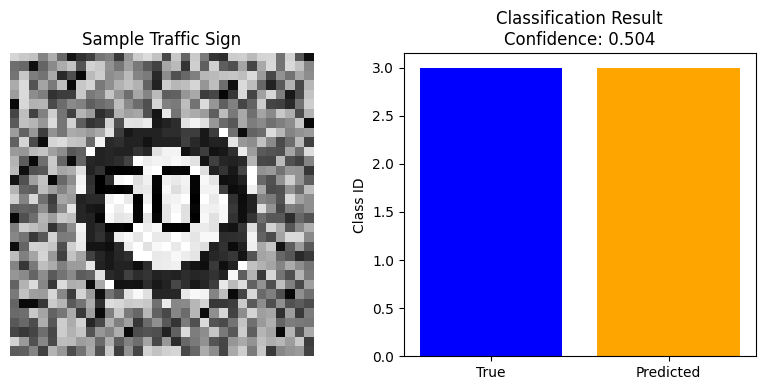

True Class: 3 (Speed limit (60km/h))
Predicted Class: 3 (Speed limit (60km/h))
Confidence: 0.5041
Correct Prediction: True


In [11]:
def predict_traffic_sign(model, image, class_names):
    if len(image.shape) == 4:
        image = image[0]
    
    prediction = model.predict(np.expand_dims(image, axis=0))
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction)
    
    return predicted_class, confidence

sample_idx = np.random.randint(0, len(X_test))
sample_image = X_test[sample_idx]
true_label = y_true_classes[sample_idx]

predicted_class, confidence = predict_traffic_sign(model, sample_image, class_names)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title(f'Sample Traffic Sign')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.bar(['True', 'Predicted'], [true_label, predicted_class], color=['blue', 'orange'])
plt.title(f'Classification Result\nConfidence: {confidence:.3f}')
plt.ylabel('Class ID')

plt.tight_layout()
plt.show()

print(f"True Class: {true_label} ({class_names[true_label] if true_label < len(class_names) else 'Unknown'})")
print(f"Predicted Class: {predicted_class} ({class_names[predicted_class] if predicted_class < len(class_names) else 'Unknown'})")
print(f"Confidence: {confidence:.4f}")
print(f"Correct Prediction: {true_label == predicted_class}")